In [1]:
import json
import pandas as pd
import numpy as np
import networkx as nx
import jellyfish
import os
import shutil
import subprocess
import requests
from github import Github
from git import Repo
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from zipfile import ZipFile
from filecmp import dircmp
import configparser
import h2o

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:149: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.16.2
  UserWarning)


## Result Gathering

In [46]:
main_df = None
directory = "Effort_Estimation_Results/"
for filename in os.listdir(directory):
    print(filename)
    if main_df is None:
        main_df = pd.read_csv(os.path.join(directory, filename))
        main_df['project_name'] = filename.replace('.csv', '')
    else:
        temp_df = pd.read_csv(os.path.join(directory, filename))
        temp_df['project_name'] = filename.replace('.csv', '')
        frames = [main_df, temp_df]
        main_df = pd.concat(frames)

Alluxio.csv
Assertj-core.csv
Atmosphere.csv
AxonFramework.csv
Beam.csv
Byte-buddy.csv
Camel.csv
Cassandra.csv
Cxf.csv
Dbeaver.csv
Hadoop.csv
karaf.csv
Okhttp.csv
Openapi-generator.csv
Orientdb.csv
Redisson.csv
Spotbugs.csv
Spring-framework.csv
Spring-security.csv
Storm.csv
Testcontainers-java.csv
Traccar.csv


In [47]:
main_df.head()

latest_commit  \
0  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
1  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
2  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
3  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
4  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   

                       commit_compared_with  num_dependency  \
0  6d501cabf03a0af22f13ca88a9c791ec21edaaeb           632.0   
1  85724a0b2c9114d94e2b9c6ffe2112bb319f692b            25.0   
2  a4dc54f7dc0333da096aa779dbaa79060c90d1ad           255.0   
3  f9f22097ce44cafe15bfeb6ec56cbf1c7e8659b3           166.0   
4  c9b564fe0e2e928b3b8583d8778b58031fe279fa         19589.0   

   num_line_affected  actual_num_of_classes_touched   latest_commit_date  \
0                 35                              4  2021-08-04 22:21:34   
1                 44                              3  2021-08-04 22:21:34   
2                118                              2  2021-08-04 22:21:34   
3                144                              5  2021-08-04 22:21:34   
4                288                             37  2021-08-04 22:21:34   

  commit_compared_with_date project_name author author_email  
0       2021-06-07 19:51:51      Alluxio    NaN          NaN  
1       2021-06-08 15:53:29      Alluxio    NaN          NaN  
2       2021-06-09 18:09:26      Alluxio    NaN          NaN  
3       2021-06-14 00:22:17      Alluxio    NaN          NaN  
4       2021-06-14 00:23:51      Alluxio    NaN          NaN

In [48]:
len(main_df)

15628

In [49]:
main_df['latest_commit_date'] = pd.to_datetime(main_df['latest_commit_date'])
main_df['commit_compared_with_date'] = pd.to_datetime(main_df['commit_compared_with_date'])
#main_df['time_taken_days'] = (main_df['latest_commit_date'] - main_df['commit_compared_with_date']).dt.round("D")
main_df['time_taken_days'] = (main_df['latest_commit_date'] - main_df['commit_compared_with_date']).dt.days


In [50]:
main_df.head(20)

latest_commit  \
0   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
1   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
2   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
3   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
4   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
5   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
6   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
7   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
8   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
9   4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
10  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
11  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
12  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
13  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
14  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
15  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
16  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
17  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
18  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   
19  4f1d962767c5f4c37d572b4ce3f1e07cc357474a   

                        commit_compared_with  num_dependency  \
0   6d501cabf03a0af22f13ca88a9c791ec21edaaeb           632.0   
1   85724a0b2c9114d94e2b9c6ffe2112bb319f692b            25.0   
2   a4dc54f7dc0333da096aa779dbaa79060c90d1ad           255.0   
3   f9f22097ce44cafe15bfeb6ec56cbf1c7e8659b3           166.0   
4   c9b564fe0e2e928b3b8583d8778b58031fe279fa         19589.0   
5   62265d1d451e652c828c41b5f4c17dee81180fa4          1088.0   
6   0abc4df4926166a6f179a9c1d42c3c510fad558d          9043.0   
7   e254405ef62fb364d8d4d2f795d5d685f260a12e            16.0   
8   62e06ed79d09aaac54ec9b1be6d2e75536e26616         32524.0   
9   61afe3d6bb7f2249ad8f42bb42dd99984494c2f8          1192.0   
10  439fcb1d1c0f3609fdebfc548817a67c85b4f893            94.0   
11  499d2b5686f9113c25e0ce665bf5c65c7eef3a7d           160.0   
12  dfaff7f9a11eadba509f3874e8c6d8261000d409           900.0   
13  d964cd4166ce374168c06f561eb22c4f15bdfb1b            25.0   
14  61085eb9fac823d08fd8e3b15f863b9a59b66589            25.0   
15  a9f8980e121dc7483daa23159525ee095c8778b0           320.0   
16  4161cab5817b2784b8a07ca4ff19773b9958d9c5          1010.0   
17  883630425353235cc1c13bf002d518958c664882           304.0   
18  1d0c0890e70a1a7835cd03b081acc506557f9bce           306.0   
19  e1f931fcbcc540c233c2c98d67228eaa0d22c727           656.0   

    num_line_affected  actual_num_of_classes_touched  latest_commit_date  \
0                  35                              4 2021-08-04 22:21:34   
1                  44                              3 2021-08-04 22:21:34   
2                 118                              2 2021-08-04 22:21:34   
3                 144                              5 2021-08-04 22:21:34   
4                 288                             37 2021-08-04 22:21:34   
5                 277                             29 2021-08-04 22:21:34   
6                 713                             48 2021-08-04 22:21:34   
7                  19                              8 2021-08-04 22:21:34   
8                 862                             95 2021-08-04 22:21:34   
9                  14                              2 2021-08-04 22:21:34   
10                  2                              1 2021-08-04 22:21:34   
11                 77                              4 2021-08-04 22:21:34   
12               1801                             26 2021-08-04 22:21:34   
13                 80                              3 2021-08-04 22:21:34   
14                 80                              2 2021-08-04 22:21:34   
15                231                              8 2021-08-04 22:21:34   
16                190                             11 2021-08-04 22:21:34   
17                 84                              4 2021-08-04 22:21:34   
18                107                              4 2021-08-04 22:21:34   
19                 74                              4 2021-08-04 22:21:34   

   commit_compared_with_date project_name author author_email  time_taken_days  

In [97]:
# Aggregating all changes per release


## move this above groupby check
test_df = main_df[main_df['time_taken_days'] > 0]
test_df = test_df[test_df['time_taken_days'] < 30]

test_df = test_df.groupby(['latest_commit', 'project_name']).agg({'num_dependency':'sum',
                                                                  'num_line_affected':'sum',
                                                                  'actual_num_of_classes_touched':'sum',
                                                                  'time_taken_days':'min',}).reset_index()



In [98]:
columns_to_normalize = ['num_dependency', 'num_line_affected',
       'actual_num_of_classes_touched', 'time_taken_days']

In [99]:
test_df['num_dependency_norm'] = np.log(test_df['num_dependency']-test_df['num_dependency'].min())/(test_df['num_dependency'].max()-test_df['num_dependency'].min())
test_df['num_line_affected_norm'] = np.log(test_df['num_line_affected']-test_df['num_line_affected'].min())/(test_df['num_line_affected'].max()-test_df['num_line_affected'].min())
test_df['actual_num_of_classes_touched_norm'] = np.log(test_df['actual_num_of_classes_touched']-test_df['actual_num_of_classes_touched'].min())/(test_df['actual_num_of_classes_touched'].max()-test_df['actual_num_of_classes_touched'].min())

test_df = test_df.dropna()

C:\Users\tanji\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [100]:
test_df.head()

latest_commit project_name  num_dependency  \
0  00ddff42e766e834dee49eb471c0c3aefab022b2      Traccar          2538.0   
1  0372e776e7079407b932c4bb21dc2557ca194333      Dbeaver         36476.0   
2  073dfc26c7a065f5d5abf18be8cce8258a9aaa71      Dbeaver         39379.0   
3  077af6a52b9661e80b2c7edd987f17bfcc6160ec        karaf            64.0   
4  08a06a7693a31bca7b66f396ba6555cbd9d63a49     Redisson          2491.0   

   num_line_affected  actual_num_of_classes_touched  time_taken_days  \
0               2348                             91                1   
1               6914                            297                4   
2               4157                            287                1   
3                 74                              2               21   
4                551                             48               13   

   num_dependency_norm  num_line_affected_norm  \
0             0.000003                0.000010   
1             0.000004                0.000012   
2             0.000004                0.000011   
3             0.000002                0.000005   
4             0.000003                0.000008   

   actual_num_of_classes_touched_norm  
0                            0.000439  
1                            0.000555  
2                            0.000552  
3                            0.000000  
4                            0.000376

In [101]:
test_df.columns

Index(['latest_commit', 'project_name', 'num_dependency', 'num_line_affected',
       'actual_num_of_classes_touched', 'time_taken_days',
       'num_dependency_norm', 'num_line_affected_norm',
       'actual_num_of_classes_touched_norm'],
      dtype='object')

In [102]:
len(test_df)

170

In [103]:
test_df.head(20)

latest_commit  project_name  num_dependency  \
0   00ddff42e766e834dee49eb471c0c3aefab022b2       Traccar          2538.0   
1   0372e776e7079407b932c4bb21dc2557ca194333       Dbeaver         36476.0   
2   073dfc26c7a065f5d5abf18be8cce8258a9aaa71       Dbeaver         39379.0   
3   077af6a52b9661e80b2c7edd987f17bfcc6160ec         karaf            64.0   
4   08a06a7693a31bca7b66f396ba6555cbd9d63a49      Redisson          2491.0   
5   08da840cb6d3392e69870dfdc2c866a6f86577fd       Dbeaver         18551.0   
6   094f8a7c3ddcc9e2a88f3993bad8c2d31f30388c      Redisson          1512.0   
7   0ca7f6edd5d76f0a0b60ba534f0e53e81f2de80d  Assertj-core          1346.0   
8   0ddefe0ee95d954ef87991f9d5fbfa531b046d14       Dbeaver         53301.0   
9   0e799710b37250474a607cbfd63886e88daf2efe  Assertj-core          9870.0   
10  113a0a672f277a6e8181757a0c54f92d42f98ef9       Dbeaver         26050.0   
11  1541a742d1fa2633ee2251eeea72904f3447c8f5         Camel        153564.0   
12  170dc5fd5c8cdc41ca89497e377fee71832fd38d       Dbeaver         16751.0   
13  17681156616e64682ecfe3e6c8215d6d653b9696       Dbeaver         16133.0   
14  179df9d730d00cd6ecfe7907f4b5c81b5d50c2d7      Redisson          1512.0   
15  17ce2d14317b1160ec9480da549028d1827e1277       Dbeaver         92970.0   
16  18eaa8b9b8cc5795fcf6c886f3cf3931b9058ae8         Camel           114.0   
17  1a3950c164cabef352bc51c61f30612f05bc38f2           Cxf         10148.0   
18  1aaec6944ea6efa41b294c39748397f36b6caad0        Hadoop           300.0   
19  1c57aca65050a5025de92de866d6a194f15df1cc    Atmosphere         17053.0   

    num_line_affected  actual_num_of_classes_touched  time_taken_days  \
0                2348                             91                1   
1                6914                            297                4   
2                4157                            287                1   
3                  74                              2               21   
4                 551                             48               13   
5                2210                             84                1   
6                  80                              8               15   
7                 186                             10                1   
8               10829                            547                3   
9                1061                             89               17   
10               5212                            199                1   
11              53213                           2170                1   
12               3114                            219                2   
13               3946                            148                5   
14                 80                              8                4   
15               6179                            461                1   
16                229                              3                2   
17               2407                             81                3   
18                272                              4                4   
19               2846                            113               21   

    num_dependency_norm  num_line_affected_norm  \
0              0.000003                0.000010   
1              0.000004                0.000012   
2              0.000004                0.000011   
3              0.000002                0.000005   
4              0.000003                0.000008   
5              0.000004                0.000010   
6              0.000003                0.000006   
7              0.000003                0.000007   
8              0.000004                0.000012   
9              0.000004                0.000009   
10             0.000004                0.000011   
11             0.000005                0.000014   
12             0.000004                0.000011   
13             0.000004                0.000011   
14             0.000003                0.000006   
15             0.000005                0.0

## EDA

In [104]:
from pandas_profiling import ProfileReport

profile = ProfileReport(test_df, title="Pandas Profiling Report",explorative=True)
profile

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [105]:
test_df.head()

latest_commit project_name  num_dependency  \
0  00ddff42e766e834dee49eb471c0c3aefab022b2      Traccar          2538.0   
1  0372e776e7079407b932c4bb21dc2557ca194333      Dbeaver         36476.0   
2  073dfc26c7a065f5d5abf18be8cce8258a9aaa71      Dbeaver         39379.0   
3  077af6a52b9661e80b2c7edd987f17bfcc6160ec        karaf            64.0   
4  08a06a7693a31bca7b66f396ba6555cbd9d63a49     Redisson          2491.0   

   num_line_affected  actual_num_of_classes_touched  time_taken_days  \
0               2348                             91                1   
1               6914                            297                4   
2               4157                            287                1   
3                 74                              2               21   
4                551                             48               13   

   num_dependency_norm  num_line_affected_norm  \
0             0.000003                0.000010   
1             0.000004                0.000012   
2             0.000004                0.000011   
3             0.000002                0.000005   
4             0.000003                0.000008   

   actual_num_of_classes_touched_norm  
0                            0.000439  
1                            0.000555  
2                            0.000552  
3                            0.000000  
4                            0.000376

In [106]:
final_col = ['num_dependency_norm', 'num_line_affected_norm', 'actual_num_of_classes_touched_norm', 'time_taken_days']
X_col = ['num_dependency_norm', 'num_line_affected_norm', 'actual_num_of_classes_touched_norm']
Y_col = ['time_taken_days']

X = test_df[X_col]
y = test_df[Y_col]
final_df = test_df[final_col]

In [107]:
X.head()

num_dependency_norm  num_line_affected_norm  \
0             0.000003                0.000010   
1             0.000004                0.000012   
2             0.000004                0.000011   
3             0.000002                0.000005   
4             0.000003                0.000008   

   actual_num_of_classes_touched_norm  
0                            0.000439  
1                            0.000555  
2                            0.000552  
3                            0.000000  
4                            0.000376

In [108]:
y.head()

time_taken_days
0                1
1                4
2                1
3               21
4               13

In [109]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

In [110]:
h2o.init(nthreads=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------------
H2O_cluster_uptime:         26 mins 28 secs
H2O_cluster_timezone:       Asia/Kuala_Lumpur
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.7
H2O_cluster_version_age:    6 days
H2O_cluster_name:           H2O_from_python_tanji_w8q1di
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    7.983 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.3 final
--------------------------  ---------------------------------------------------------

In [119]:
from h2o.automl import H2OAutoML

full = h2o.H2OFrame(final_df)
train,test = full.split_frame(ratios=[.7])


x = train.columns
y = "time_taken_days"
x.remove(y)



Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |█Failed polling AutoML progress log: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\tanji\\AppData\\Local\\Temp\\tmpzp2gswfp.csv'
███████████████████████████████████████████████████████| 100%

00:01:18.683: AutoML: XGBoost is not available; skipping it.
00:01:24.749: Skipping training of model GBM_5_AutoML_20210909_000118 due to exception: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GBM model: GBM_5_AutoML_20210909_000118.  Details: ERRR on field: _min_rows: The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 111.0.




In [ ]:
aml = H2OAutoML(max_models=10, seed=1)
aml.train(x=x, y=y, training_frame=train)

In [120]:
lb = aml.leaderboard
lb.head(rows=lb.nrows)

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 DeepLearning_grid__1_AutoML_20210909_000118_model_1 21.5509 4.6423 21.5509 3.34313 nan 
 GLM_1_AutoML_20210909_000118 22.8723 4.7825 22.8723 3.29337 0.704719 
 StackedEnsemble_BestOfFamily_AutoML_20210909_000118 23.3276 4.82986 23.3276 3.40279 0.76158 
 GBM_4_AutoML_20210909_000118 23.5965 4.85763 23.5965 3.26594 0.700009 
 StackedEnsemble_AllModels_AutoML_20210909_000118 23.9444 4.8933 23.9444 3.34838 0.706821 
 GBM_2_AutoML_20210909_000118 24.0193 4.90094 24.0193 3.35745 0.717746 
 GBM_3_AutoML_20210909_000118 24.4422 4.9439 24.4422 3.38423 0.726089 
 DeepLearning_1_AutoML_20210909_000118 24.7851 4.97846 24.7851 3.43947 0.737331 
 GBM_grid__1_AutoML_20210909_000118_model_1 27.7625 5.26902 27.7625 3.48568 0.750001 
 DRF_1_AutoML_20210909_000118 30.7194 5.54251 30.7194 3.57594 0.77099 
 XRT_1_AutoML_20210909_000118 31.5504 5.61698 31.5504 3.6679 0.777198 
 GBM_1_AutoML_20210909_000118 35.1233 5.92649 35.1233 3.85609 0.813208

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 DeepLearning_grid__1_AutoML_20210909_000118_model_1 21.5509 4.6423 21.5509 3.34313 nan 913 0.007164 DeepLearning 
 GLM_1_AutoML_20210909_000118 22.8723 4.7825 22.8723 3.29337 0.704719 19 0.004042 GLM 
 StackedEnsemble_BestOfFamily_AutoML_20210909_000118 23.3276 4.82986 23.3276 3.40279 0.76158 111 0.037712 StackedEnsemble 
 GBM_4_AutoML_20210909_000118 23.5965 4.85763 23.5965 3.26594 0.700009 17 0.006249 GBM 
 StackedEnsemble_AllModels_AutoML_20210909_000118 23.9444 4.8933 23.9444 3.34838 0.706821 112 0.069434 StackedEnsemble 
 GBM_2_AutoML_20210909_000118 24.0193 4.90094 24.0193 3.35745 0.717746 14 0.006152 GBM 
 GBM_3_AutoML_20210909_000118 24.4422 4.9439 24.4422 3.38423 0.726089 15 0.005194 GBM 
 DeepLearning_1_AutoML_20210909_000118 24.7851 4.97846 24.7851 3.43947 0.737331 11 0.005231 DeepLearning 
 GBM_grid__1_AutoML_20210909_000118_model_1 27.7625 5.26902 27.7625 3.48568 0.750001 18 0.006844 GBM 
 DRF_1_AutoML_20210909_000118 30.7194 5.54251 30.7194 3.57594 0.77099 52 0.011615 DRF 
 XRT_1_AutoML_20210909_000118 31.5504 5.61698 31.5504 3.6679 0.777198 57 0.016318 DRF 
 GBM_1_AutoML_20210909_000118 35.1233 5.92649 35.1233 3.85609 0.813208 24 0.008572 GBM

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

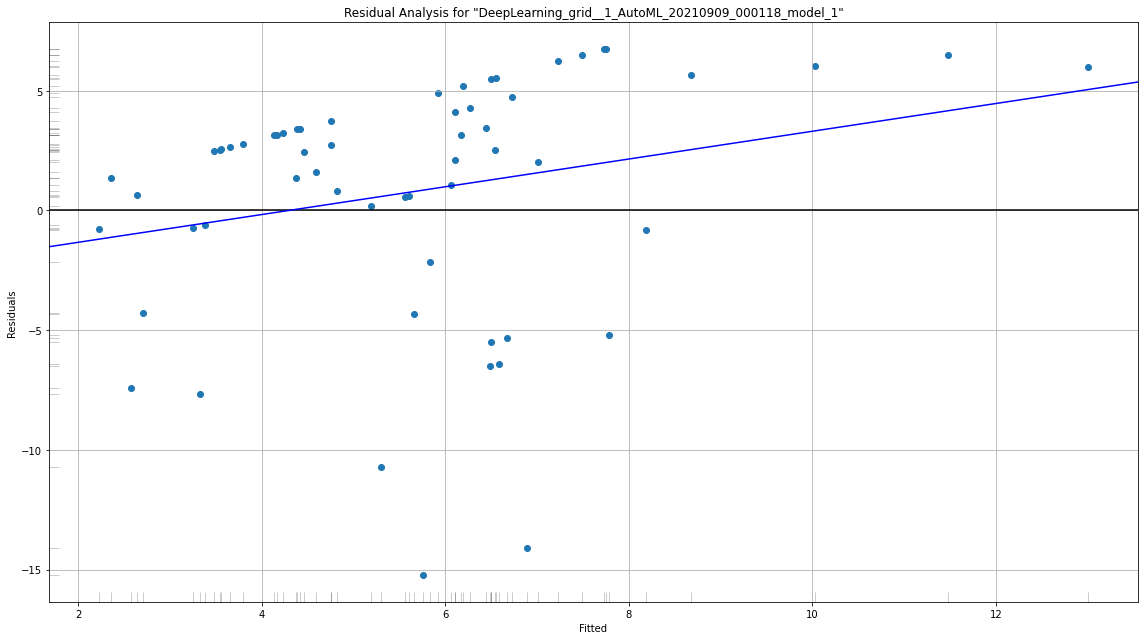

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

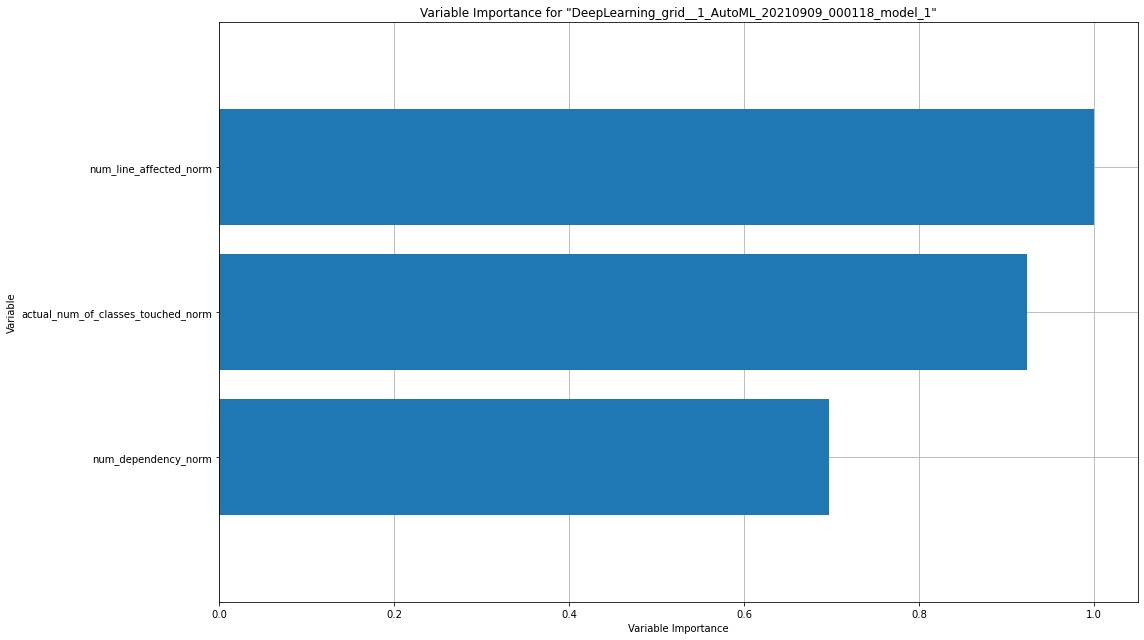

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

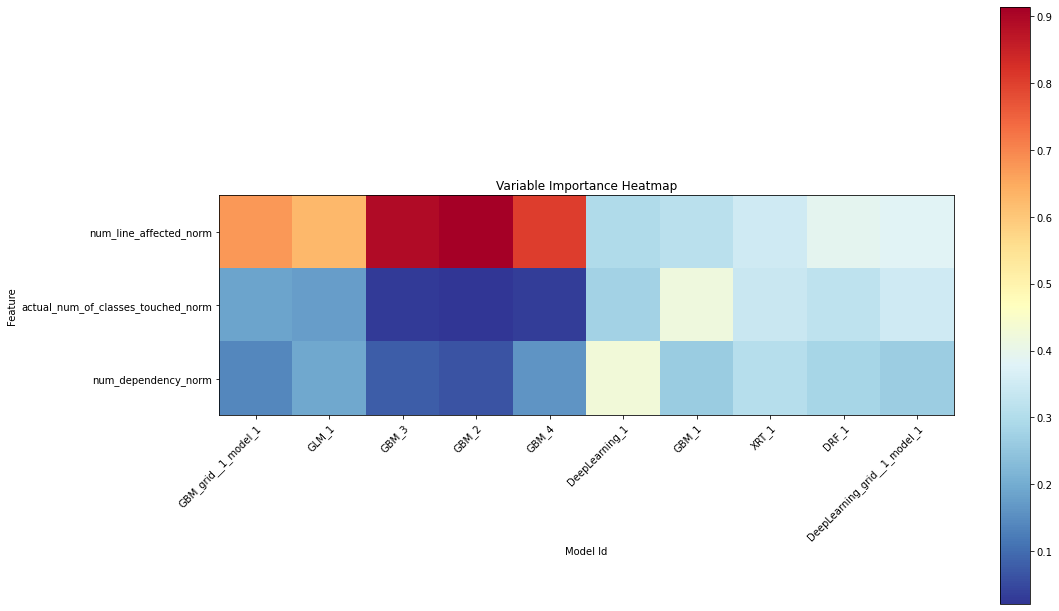

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

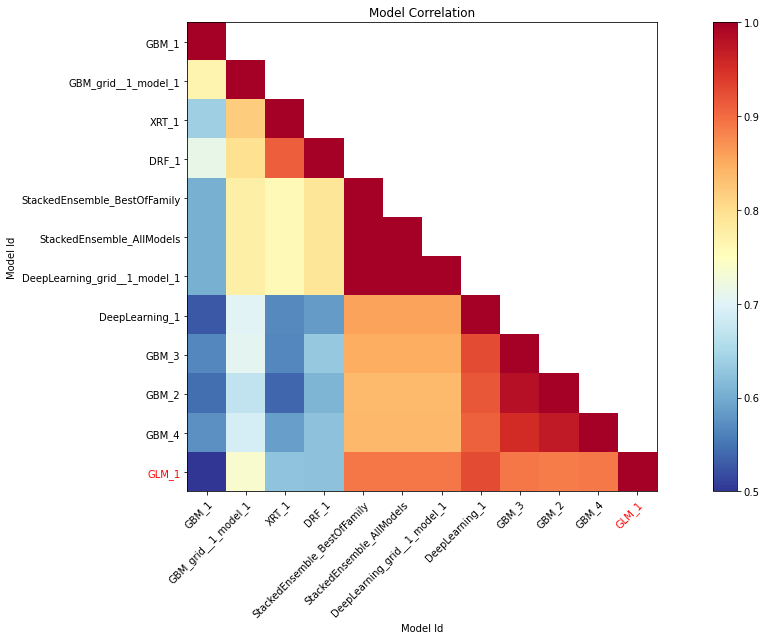

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

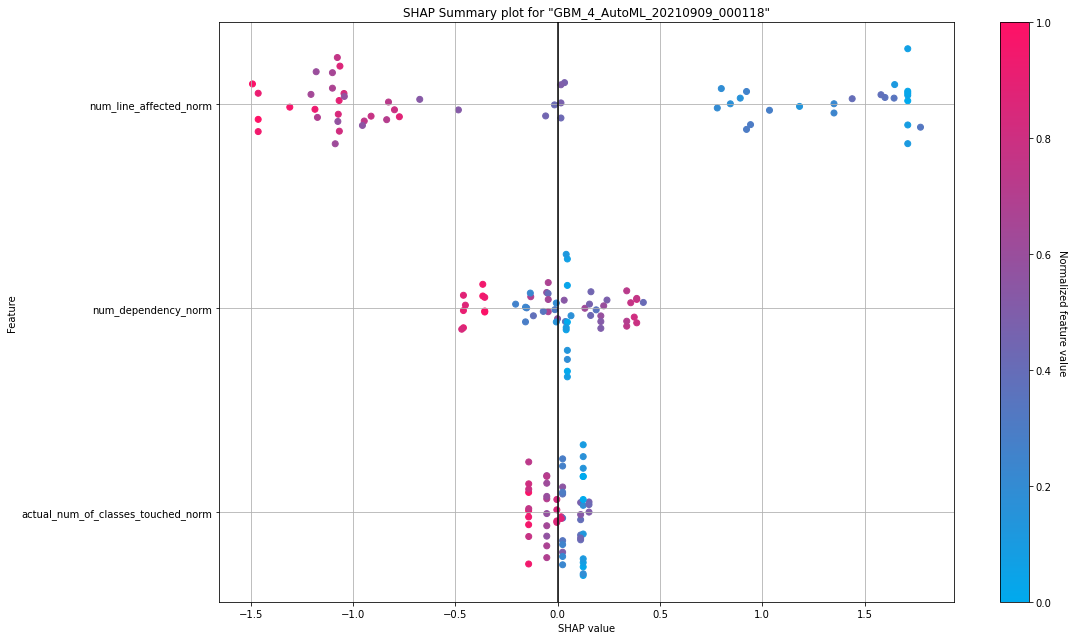

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

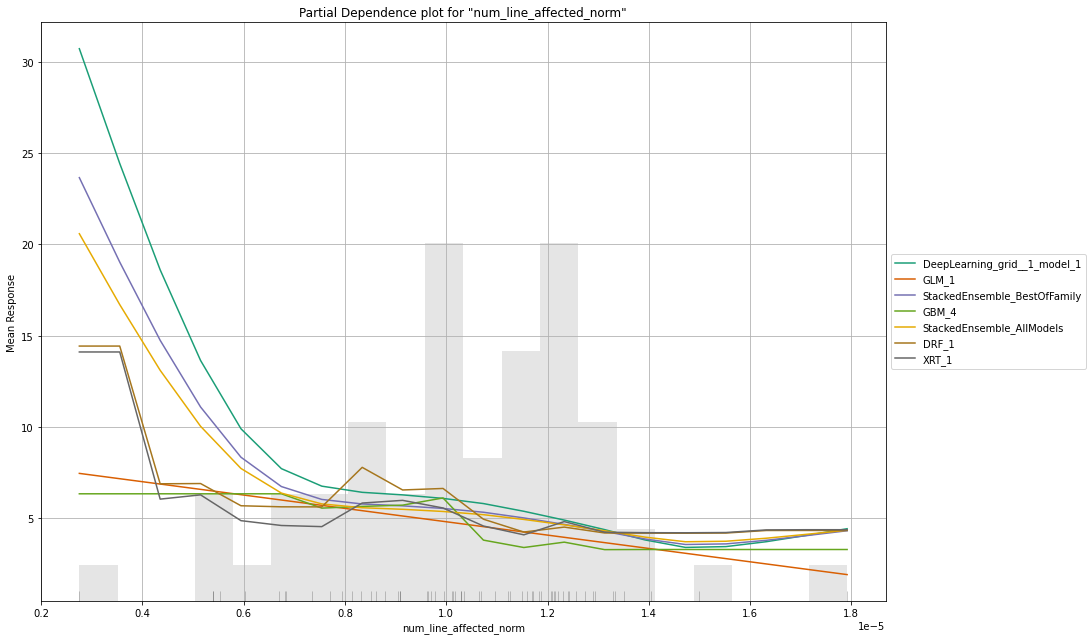

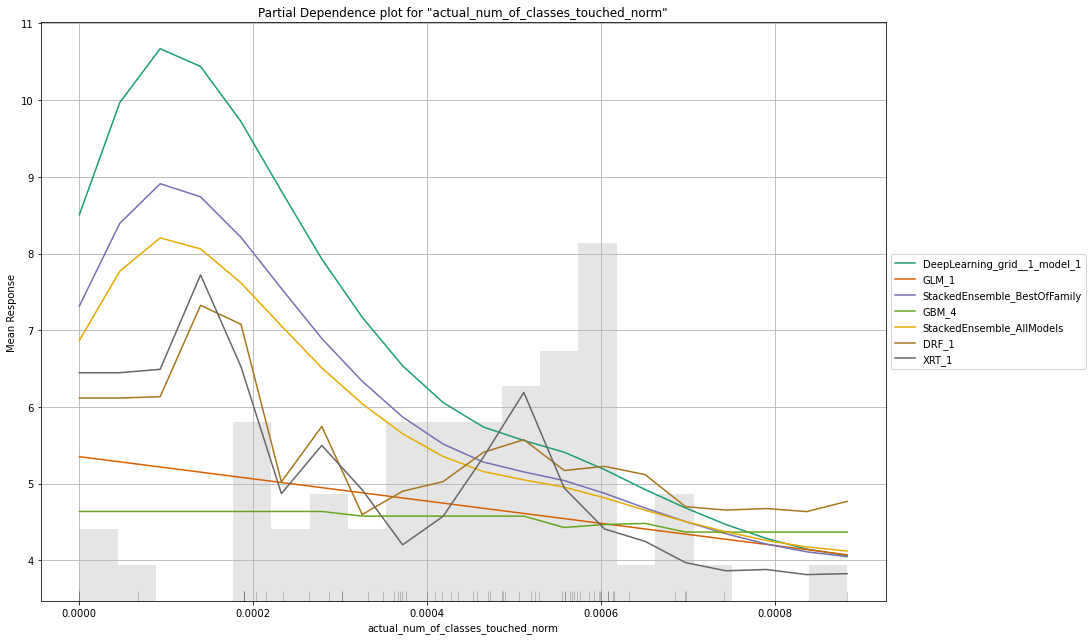

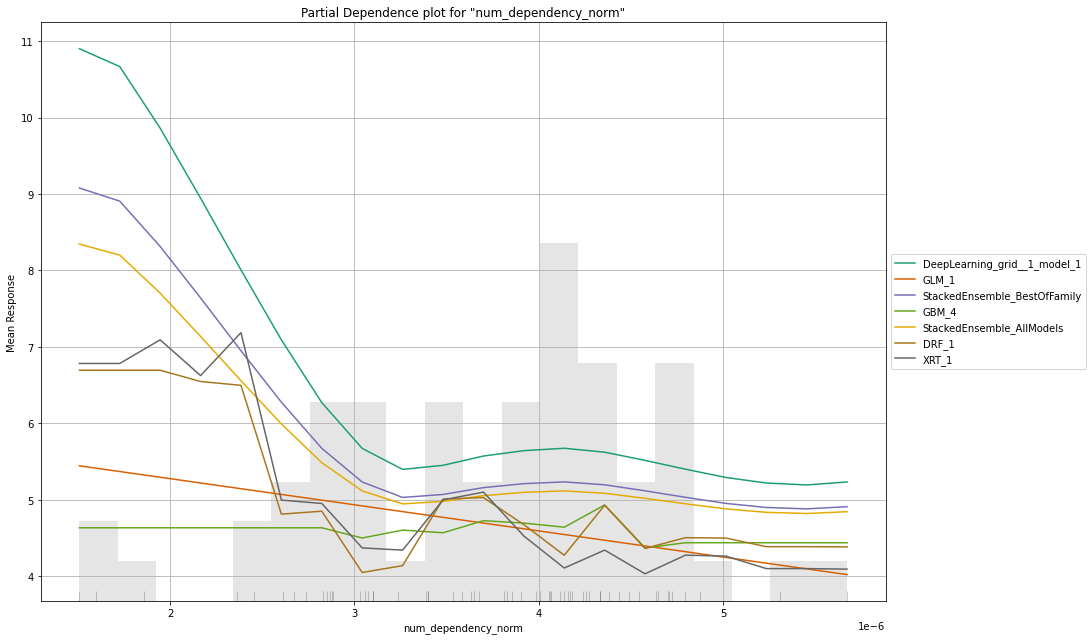

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

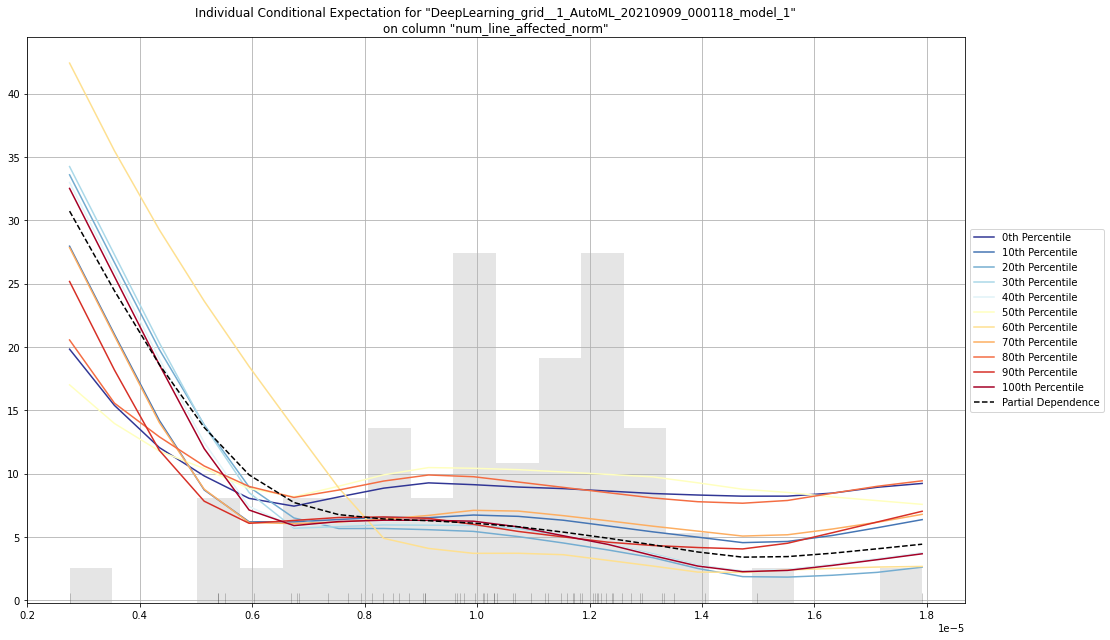

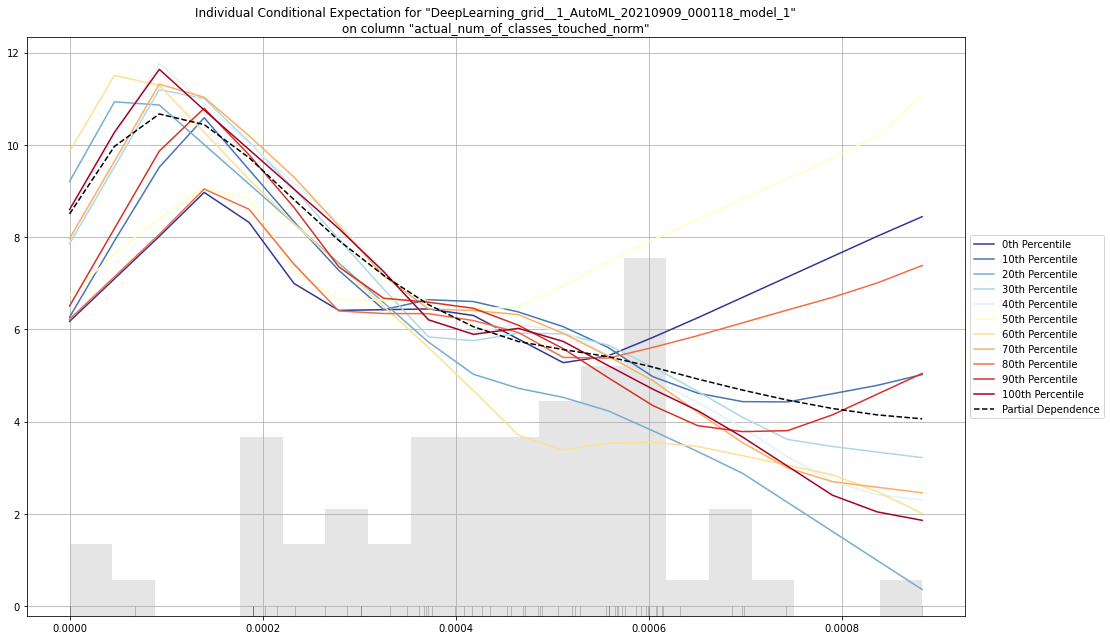

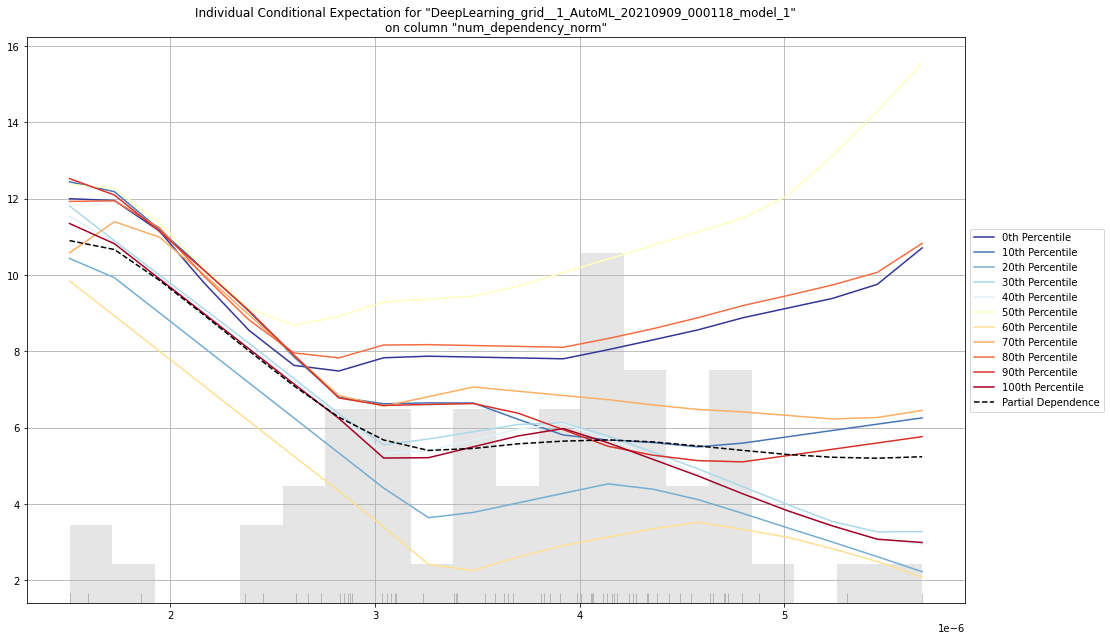

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo 
 
 
 DeepLearning_grid__1_AutoML_20210909_000118_model_1 21.5509 4.6423 21.5509 3.34313 nan 913 0.007164 DeepLearning 
 GLM_1_AutoML_20210909_000118 22.8723 4.7825 22.8723 3.29337 0.704719 19 0.004042 GLM 
 StackedEnsemble_BestOfFamily_AutoML_20210909_000118 23.3276 4.82986 23.3276 3.40279 0.76158 111 0.037712 StackedEnsemble 
 GBM_4_AutoML_20210909_000118 23.5965 4.85763 23.5965 3.26594 0.700009 17 0.006249 GBM 
 StackedEnsemble_AllModels_AutoML_20210909_000118 23.9444 4.8933 23.9444 3.34838 0.706821 112 0.069434 StackedEnsemble 
 GBM_2_AutoML_20210909_000118 24.0193 4.90094 24.0193 3.35745 0.717746 14 0.006152 GBM 
 GBM_3_AutoML_20210909_000118 24.4422 4.9439 24.4422 3.38423 0.726089 15 0.005194 GBM 
 DeepLearning_1_AutoML_20210909_000118 24.7851 4.97846 24.7851 3.43947 0.737331 11 0.005231 DeepLearning 
 GBM_grid__1_AutoML_20210909_000118_model_1 27.7625 5.26902 27.7625 3.48568 0.750001 18 0.006844 GBM 
 DRF_1_AutoML_20210909_000118 30.7194 5.54251 30.7194 3.57594 0.77099 52 0.011615 DRF 
 XRT_1_AutoML_20210909_000118 31.5504 5.61698 31.5504 3.6679 0.777198 57 0.016318 DRF 
 GBM_1_AutoML_20210909_000118 35.1233 5.92649 35.1233 3.85609 0.813208 24 0.008572 GBM

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

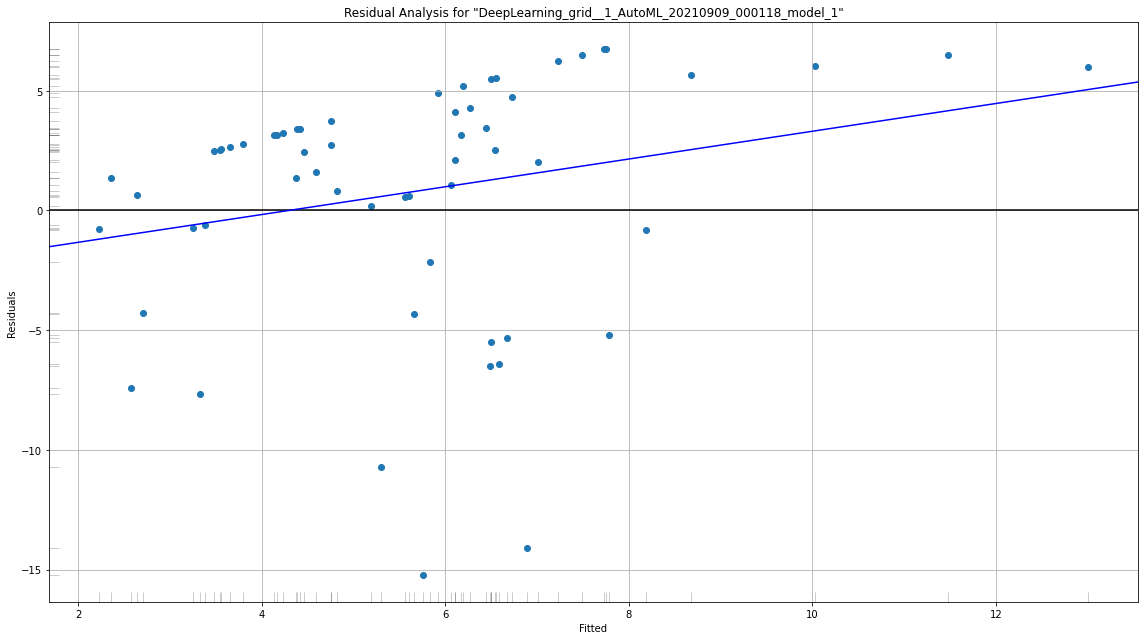

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

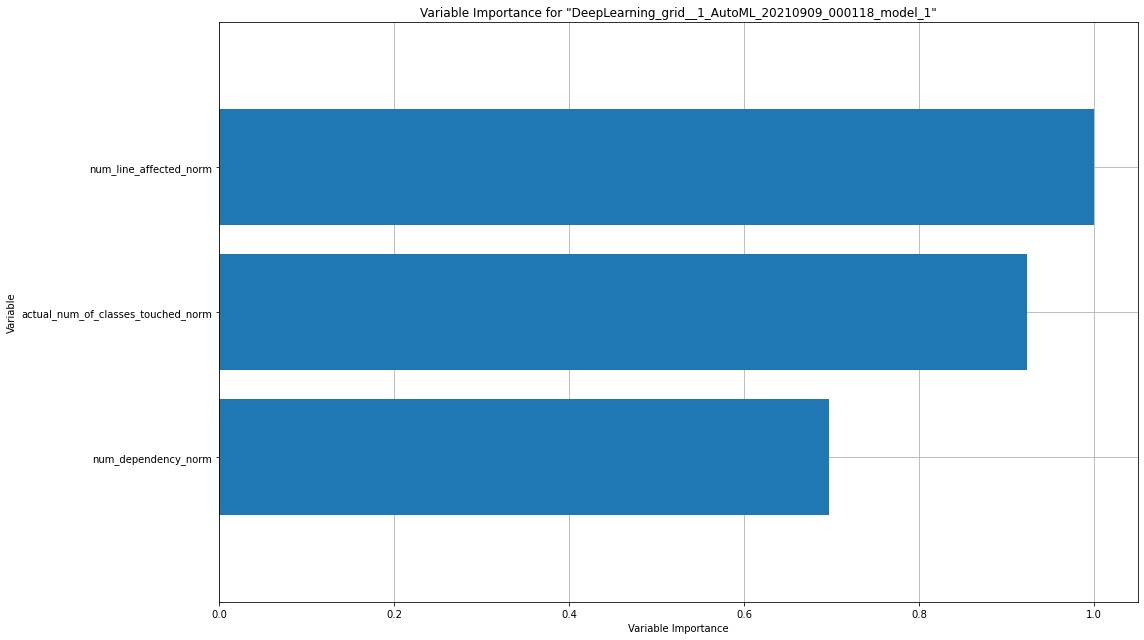

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

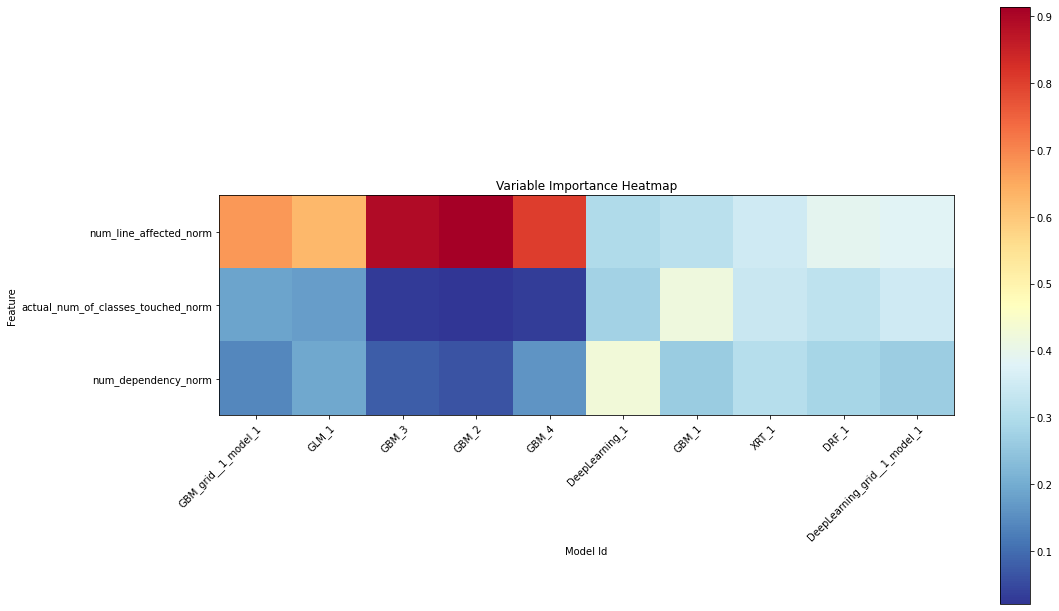

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

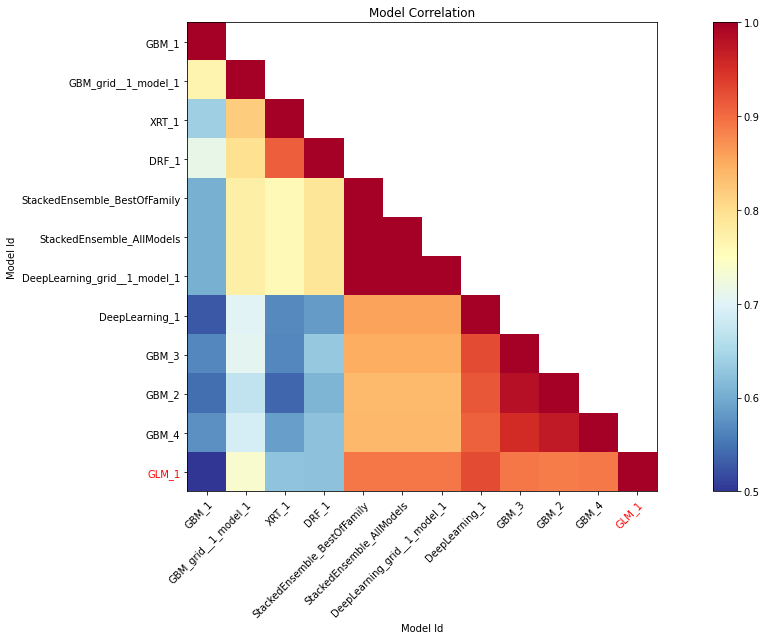

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

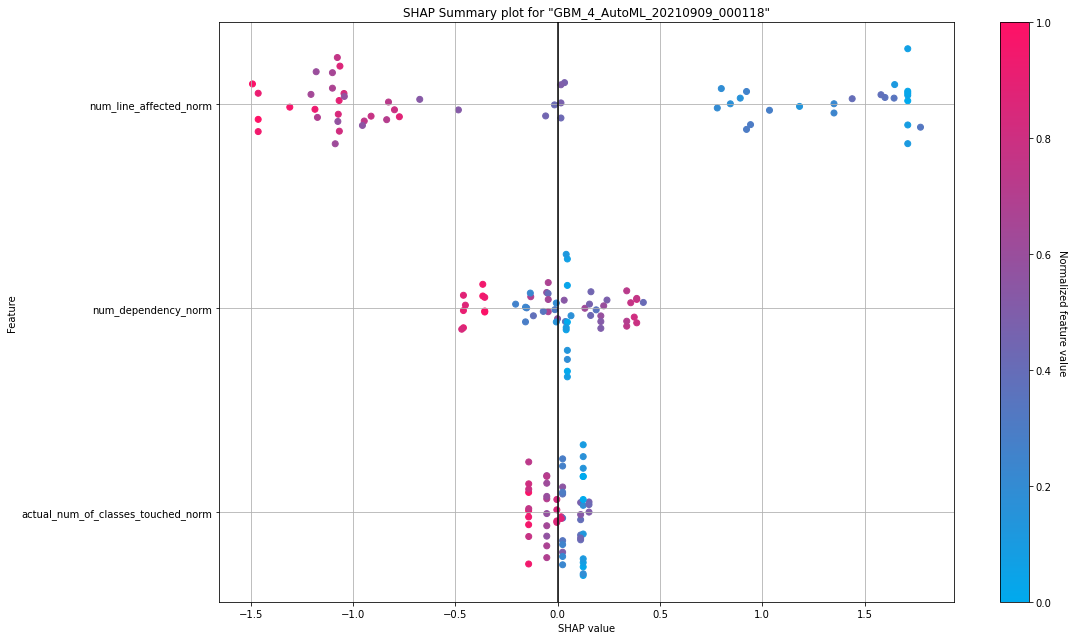

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

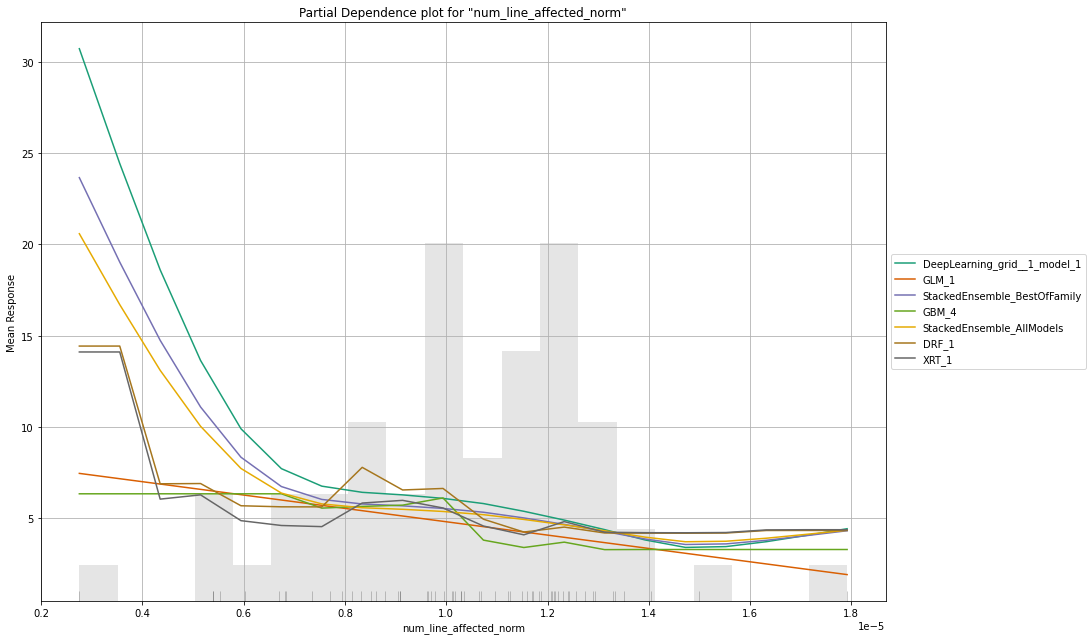

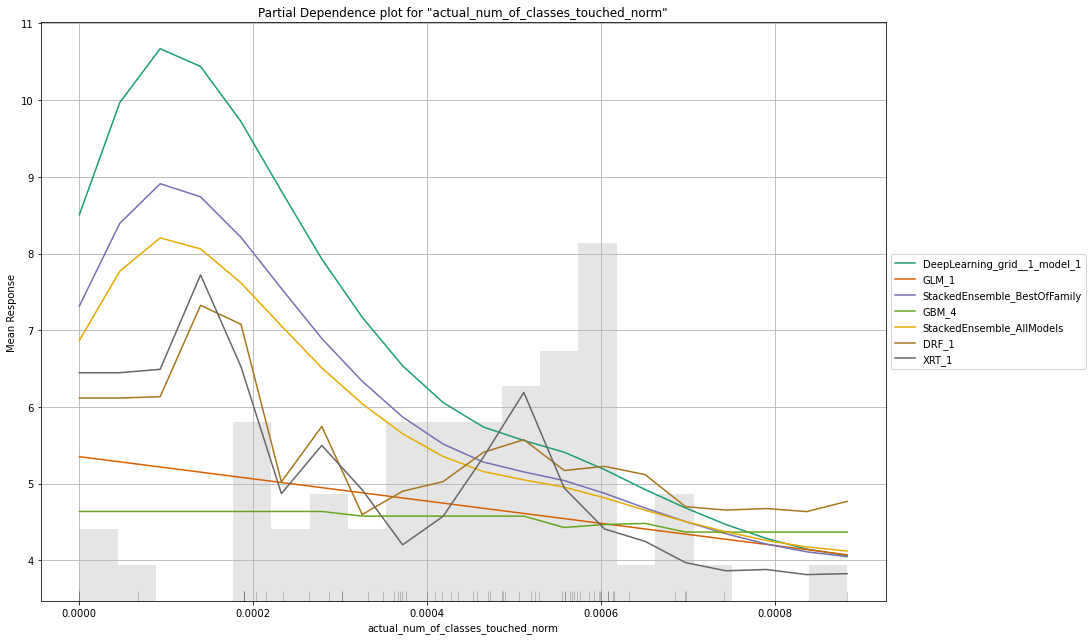

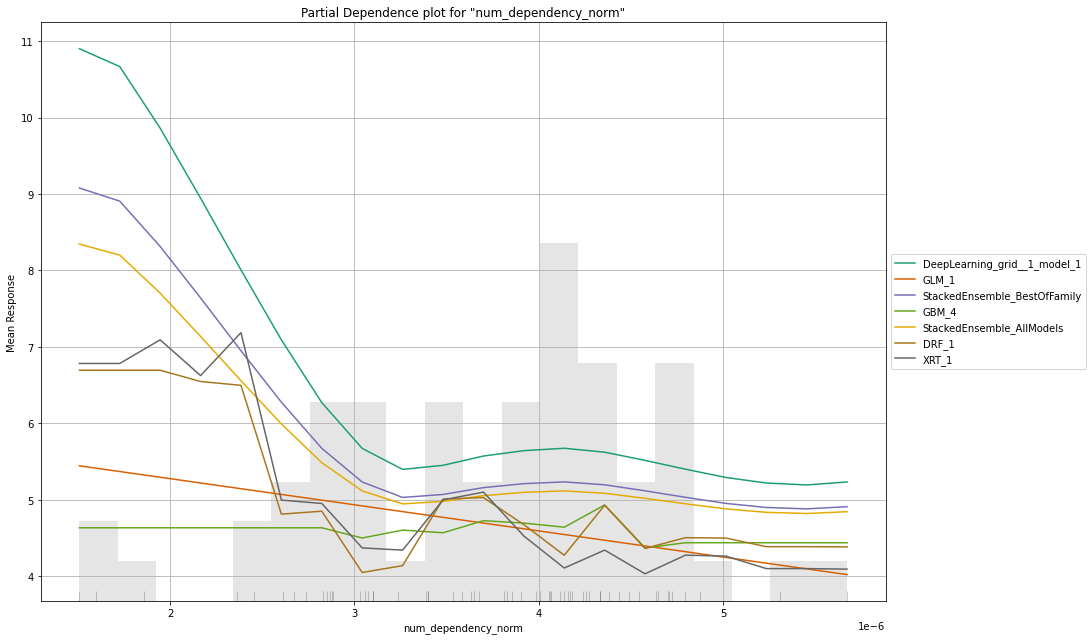

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

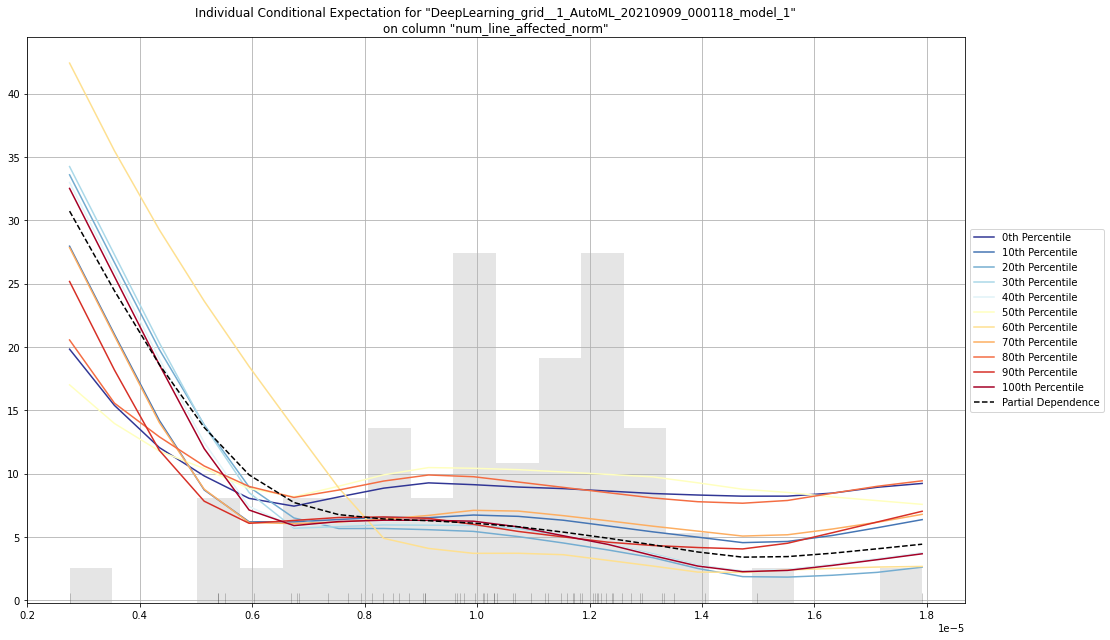

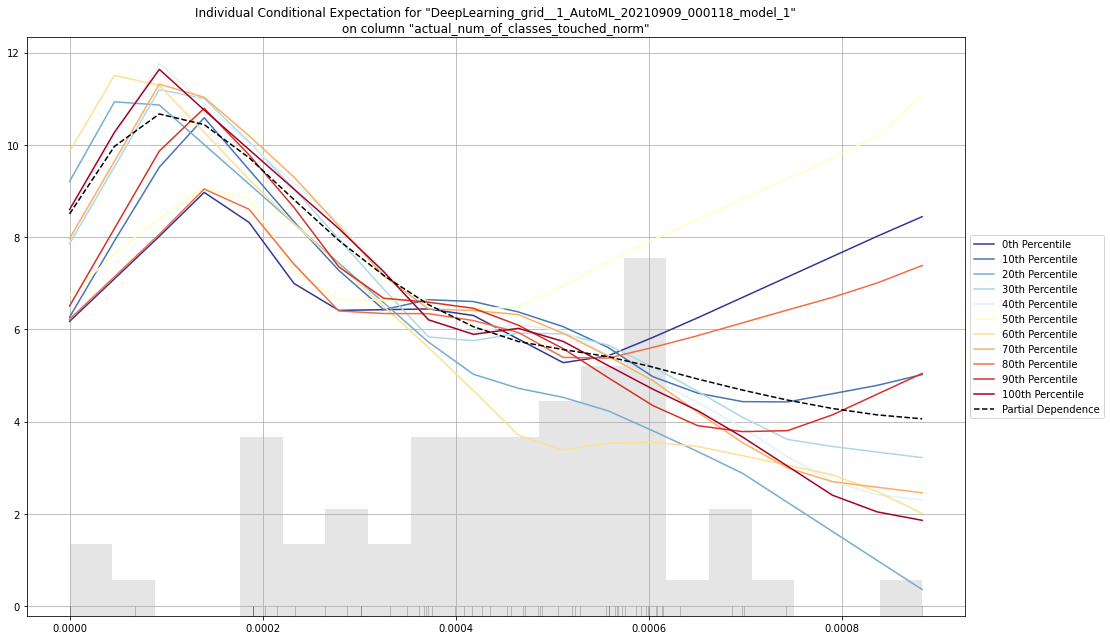

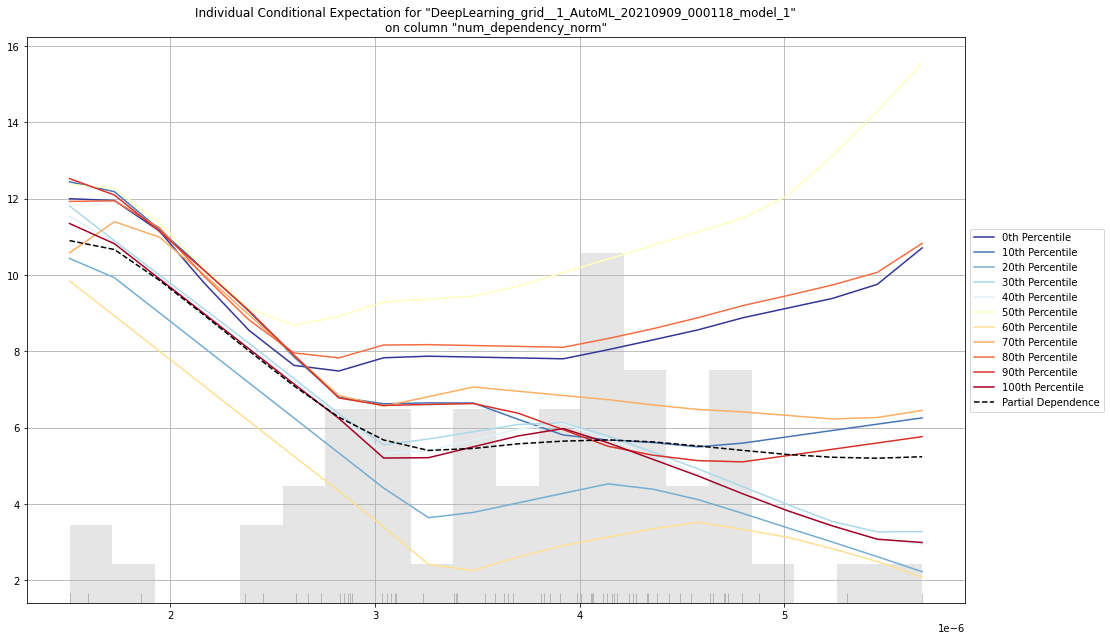

In [121]:
aml.explain(test)

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo predict 
 
 
 DeepLearning_grid__1_AutoML_20210909_000118_model_1 21.5509 4.6423 21.5509 3.34313 nan 913 0.007164 DeepLearning 4.82211 
 GLM_1_AutoML_20210909_000118 22.8723 4.7825 22.8723 3.29337 0.704719 19 0.004042 GLM 3.89618 
 StackedEnsemble_BestOfFamily_AutoML_20210909_000118 23.3276 4.82986 23.3276 3.40279 0.76158 111 0.037712 StackedEnsemble 4.60763 
 GBM_4_AutoML_20210909_000118 23.5965 4.85763 23.5965 3.26594 0.700009 17 0.006249 GBM 3.12417 
 StackedEnsemble_AllModels_AutoML_20210909_000118 23.9444 4.8933 23.9444 3.34838 0.706821 112 0.069434 StackedEnsemble 4.59109 
 GBM_2_AutoML_20210909_000118 24.0193 4.90094 24.0193 3.35745 0.717746 14 0.006152 GBM 3.43204 
 GBM_3_AutoML_20210909_000118 24.4422 4.9439 24.4422 3.38423 0.726089 15 0.005194 GBM 3.44832 
 DeepLearning_1_AutoML_20210909_000118 24.7851 4.97846 24.7851 3.43947 0.737331 11 0.005231 DeepLearning 3.98929 
 GBM_grid__1_AutoML_20210909_000118_model_1 27.7625 5.26902 27.7625 3.48568 0.750001 18 0.006844 GBM 3.67612 
 DRF_1_AutoML_20210909_000118 30.7194 5.54251 30.7194 3.57594 0.77099 52 0.011615 DRF 2.35185

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

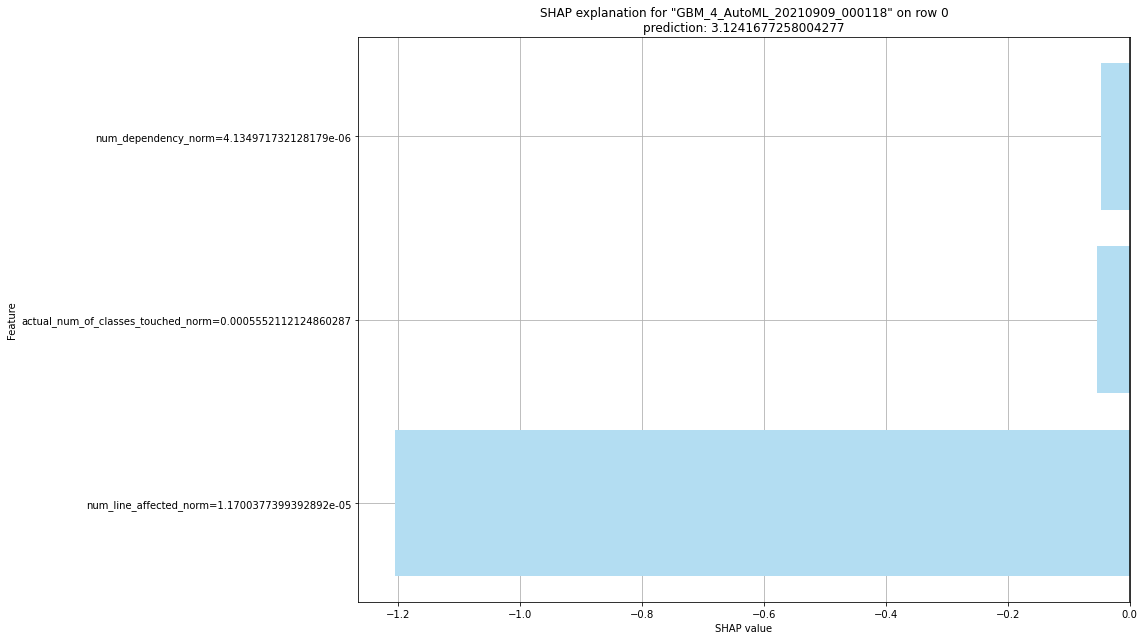

# Leaderboard

> Leaderboard shows models with their metrics and their predictions for a given row. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id mean_residual_deviance rmse mse mae rmsle training_time_ms predict_time_per_row_ms algo predict 
 
 
 DeepLearning_grid__1_AutoML_20210909_000118_model_1 21.5509 4.6423 21.5509 3.34313 nan 913 0.007164 DeepLearning 4.82211 
 GLM_1_AutoML_20210909_000118 22.8723 4.7825 22.8723 3.29337 0.704719 19 0.004042 GLM 3.89618 
 StackedEnsemble_BestOfFamily_AutoML_20210909_000118 23.3276 4.82986 23.3276 3.40279 0.76158 111 0.037712 StackedEnsemble 4.60763 
 GBM_4_AutoML_20210909_000118 23.5965 4.85763 23.5965 3.26594 0.700009 17 0.006249 GBM 3.12417 
 StackedEnsemble_AllModels_AutoML_20210909_000118 23.9444 4.8933 23.9444 3.34838 0.706821 112 0.069434 StackedEnsemble 4.59109 
 GBM_2_AutoML_20210909_000118 24.0193 4.90094 24.0193 3.35745 0.717746 14 0.006152 GBM 3.43204 
 GBM_3_AutoML_20210909_000118 24.4422 4.9439 24.4422 3.38423 0.726089 15 0.005194 GBM 3.44832 
 DeepLearning_1_AutoML_20210909_000118 24.7851 4.97846 24.7851 3.43947 0.737331 11 0.005231 DeepLearning 3.98929 
 GBM_grid__1_AutoML_20210909_000118_model_1 27.7625 5.26902 27.7625 3.48568 0.750001 18 0.006844 GBM 3.67612 
 DRF_1_AutoML_20210909_000118 30.7194 5.54251 30.7194 3.57594 0.77099 52 0.011615 DRF 2.35185

# SHAP Explanation

> SHAP explanation shows contribution of features for a given instance. The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function. H2O implements TreeSHAP which when the features are correlated, can increase contribution of a feature that had no influence on the prediction.

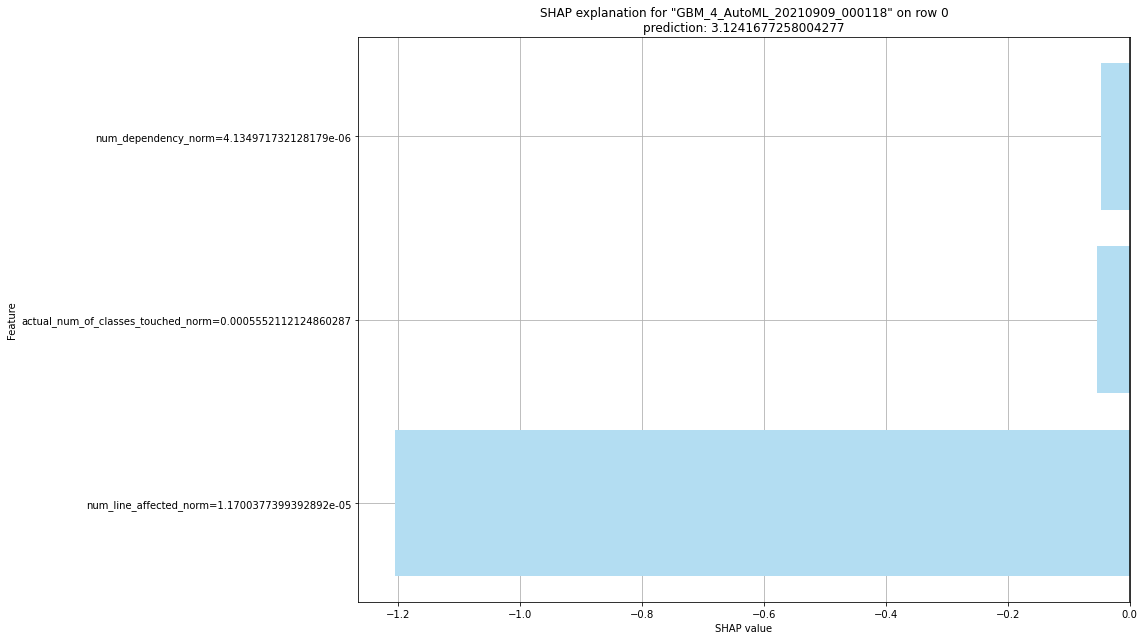

In [122]:
aml.explain_row(test, row_index=0)

In [44]:
h2o.shutdown()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  """Entry point for launching an IPython kernel.
